In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../../Train.csv')

# Display the first few rows to check for a column that might indicate holidays
print(df.head())


             date_time is_holiday  air_pollution_index  humidity  wind_speed  \
0  2012-10-02 09:00:00       None                  121        89           2   
1  2012-10-02 10:00:00       None                  178        67           3   
2  2012-10-02 11:00:00       None                  113        66           3   
3  2012-10-02 12:00:00       None                   20        66           3   
4  2012-10-02 13:00:00       None                  281        65           3   

   wind_direction  visibility_in_miles  dew_point  temperature  rain_p_h  \
0             329                    1          1       288.28       0.0   
1             330                    1          1       289.36       0.0   
2             329                    2          2       289.58       0.0   
3             329                    5          5       290.13       0.0   
4             329                    7          7       291.14       0.0   

   snow_p_h  clouds_all weather_type weather_description  traf

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../../Train.csv')

# Check unique values in the 'is_holiday' column
print(df['is_holiday'].unique())

# Convert any value that is not 'None' to 1 (indicating a holiday) and 'None' to 0
df['is_holiday'] = df['is_holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Verify the conversion
print(df['is_holiday'].value_counts())


['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
0    33707
1       43
Name: is_holiday, dtype: int64


In [3]:
# Group by the 'is_holiday' column and calculate average traffic volume
average_traffic_by_holiday = df.groupby('is_holiday')['traffic_volume'].mean()
print(average_traffic_by_holiday)

is_holiday
0    3243.182395
1     838.116279
Name: traffic_volume, dtype: float64


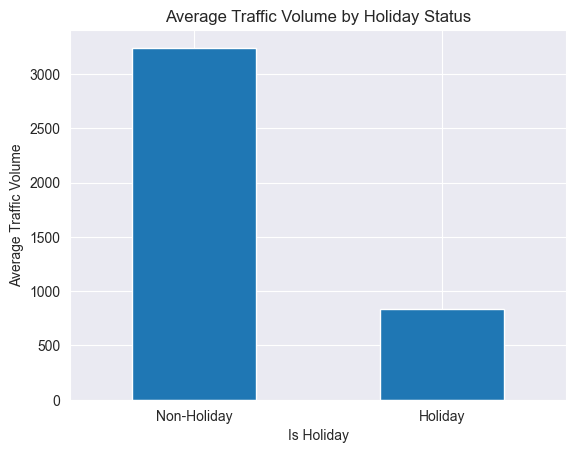

In [4]:
import matplotlib.pyplot as plt

# Plot average traffic volume by holiday status
average_traffic_by_holiday.plot(kind='bar')
plt.title('Average Traffic Volume by Holiday Status')
plt.xlabel('Is Holiday')
plt.ylabel('Average Traffic Volume')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

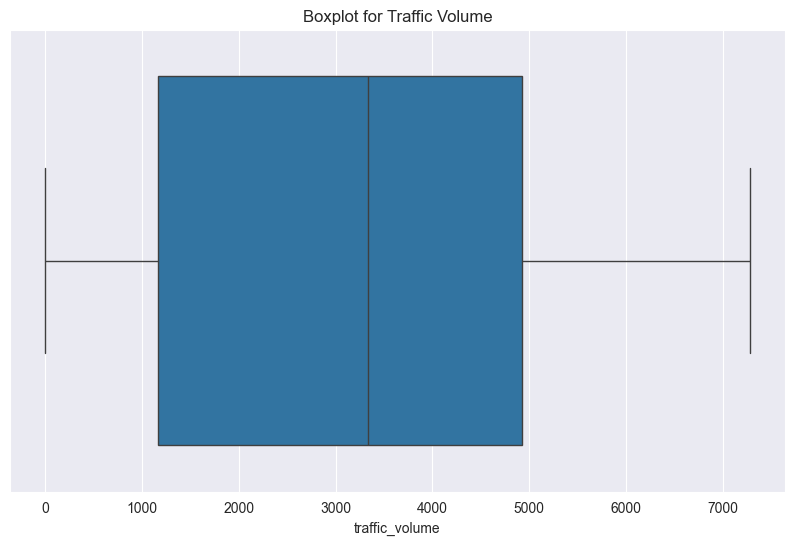

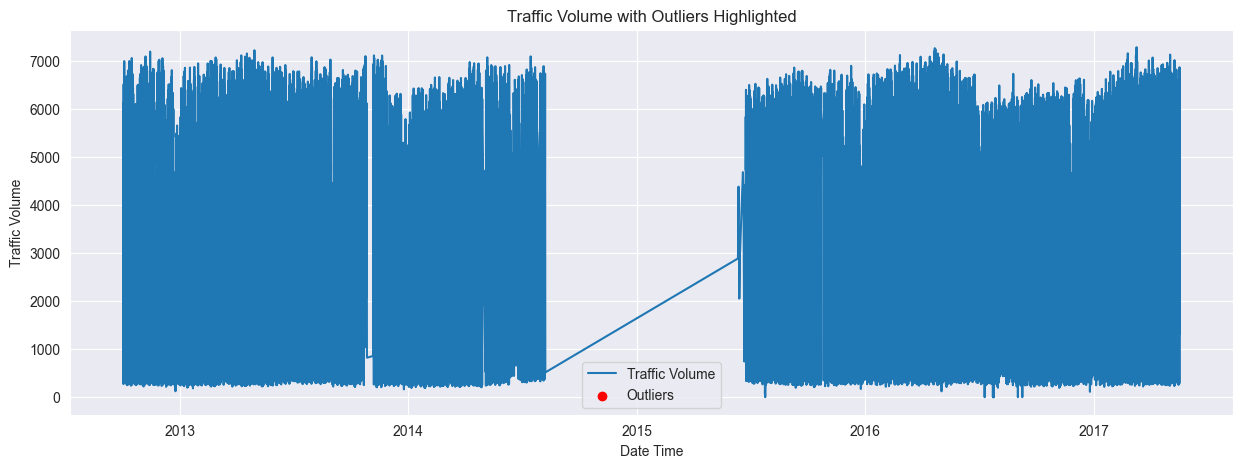

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_raw = pd.read_csv('../../Train.csv')
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Drop rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Calculate IQR for outlier detection
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
outliers = df[(df[target] < (Q1 - 1.5 * IQR)) | (df[target] > (Q3 + 1.5 * IQR))]

# Plot to visualize outliers using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[target])
plt.title('Boxplot for Traffic Volume')
plt.show()

# Plot a time series graph highlighting outliers
plt.figure(figsize=(15, 5))
plt.plot(df.index, df[target], label='Traffic Volume')
plt.scatter(outliers.index, outliers[target], color='red', label='Outliers', zorder=5)
plt.title('Traffic Volume with Outliers Highlighted')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Load the dataset
df_raw = pd.read_csv('../../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)

start_of_C = '2015-06-11 20:00:00'
df_period_C = df_raw[df_raw['date_time'] >= start_of_C]

# Extracting non-numeric columns
non_numeric_cols = ['is_holiday', 'weather_type', 'weather_description']

# Group by 'date_time' and aggregate
agg_funcs = {col: 'mean' for col in df_period_C.columns if col not in non_numeric_cols}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_cols})
df_aggregated = df_period_C.groupby('date_time').agg(agg_funcs)

# One-hot encode categorical features
df = pd.get_dummies(df_aggregated, columns=non_numeric_cols, drop_first=True)

# Add hour from the index
df['hour'] = df.index.hour

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Save 'date_time' for later use if needed
date_time = df['date_time']

# Exclude 'date_time' from the scaling process and model input
X = df.drop(['date_time', target], axis=1)
y = df[target]

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into train and test sets
split_index = int(len(X_scaled) * 0.9)
X_train = X_scaled[:split_index]
y_train = y[:split_index]
X_test = X_scaled[split_index:]
y_test = y[split_index:]

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Train the model on the scaled data
xgboost_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(xgboost_model, 'xgboost_model_default_parameters.joblib')

# Evaluate metrics on the training set
y_train_pred = xgboost_model.predict(X_train)
train_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'MSE': mean_squared_error(y_train, y_train_pred),
    'MAE': mean_absolute_error(y_train, y_train_pred),
    'MAPE': mape_scorer(y_train, y_train_pred)
}

# Evaluate metrics on the validation set
y_val_pred = xgboost_model.predict(X_test)
val_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred)),
    'MSE': mean_squared_error(y_test, y_val_pred),
    'MAE': mean_absolute_error(y_test, y_val_pred),
    'MAPE': mape_scorer(y_test, y_val_pred)
}

# Print and compare metrics
print("Training Set Metrics:")
print(train_metrics)

print("\nValidation Set Metrics:")
print(val_metrics)


Training Set Metrics:
{'RMSE': 198.52884320807124, 'MSE': 39413.70158553493, 'MAE': 138.27009042498474, 'MAPE': 18.595516112982775}

Validation Set Metrics:
{'RMSE': 324.4534871942481, 'MSE': 105270.06535250813, 'MAE': 209.02695933031012, 'MAPE': 9.807200302307441}


In [7]:
df

,date_time,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,...,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with light rain,weather_description_very heavy rain,hour,traffic_volume_lag_1,traffic_volume_lag_2,traffic_volume_lag_3,traffic_volume_rolling_mean,traffic_volume_rolling_std
date_time,,,,,,,,,,,,,,,,,,,,,
2015-06-12 21:00:00,2015-06-12 21:00:00,29.000000,63.0,2.0,320.0,5.000000,5.000000,292.061,0.0,0.0,...,0,0,0,0,21,3095.0,4380.0,2886.0,3453.666667,809.005768
2015-06-13 21:00:00,2015-06-13 21:00:00,78.000000,68.0,3.0,322.0,3.000000,3.000000,294.840,0.0,0.0,...,0,0,0,0,21,3299.0,3095.0,4380.0,3591.333333,690.579708
2015-06-13 23:00:00,2015-06-13 23:00:00,179.000000,66.0,2.0,318.0,2.000000,2.000000,293.137,0.0,0.0,...,0,0,0,0,23,3040.0,3299.0,3095.0,3144.666667,136.456342
2015-06-14 20:00:00,2015-06-14 20:00:00,163.000000,70.0,2.0,318.0,5.000000,5.000000,296.064,0.0,0.0,...,0,0,0,0,20,2051.0,3040.0,3299.0,2796.666667,658.623059
2015-06-19 18:00:00,2015-06-19 18:00:00,115.000000,70.0,2.0,320.0,2.000000,2.000000,299.007,0.0,0.0,...,0,0,0,0,18,2909.0,2051.0,3040.0,2666.666667,537.191152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-17 19:00:00,2017-05-17 19:00:00,112.333333,84.0,1.0,321.0,5.000000,5.000000,290.560,0.0,0.0,...,0,0,0,0,19,4864.0,5763.0,6426.0,5684.333333,783.965773
2017-05-17 20:00:00,2017-05-17 20:00:00,173.666667,86.0,1.0,326.0,4.000000,4.000000,288.890,0.0,0.0,...,0,0,0,0,20,3136.0,4864.0,5763.0,4587.666667,1335.122591
2017-05-17 21:00:00,2017-05-17 21:00:00,122.666667,85.0,1.0,328.0,6.666667,6.666667,287.880,0.0,0.0,...,0,0,0,0,21,2733.0,3136.0,4864.0,3577.666667,1132.074350


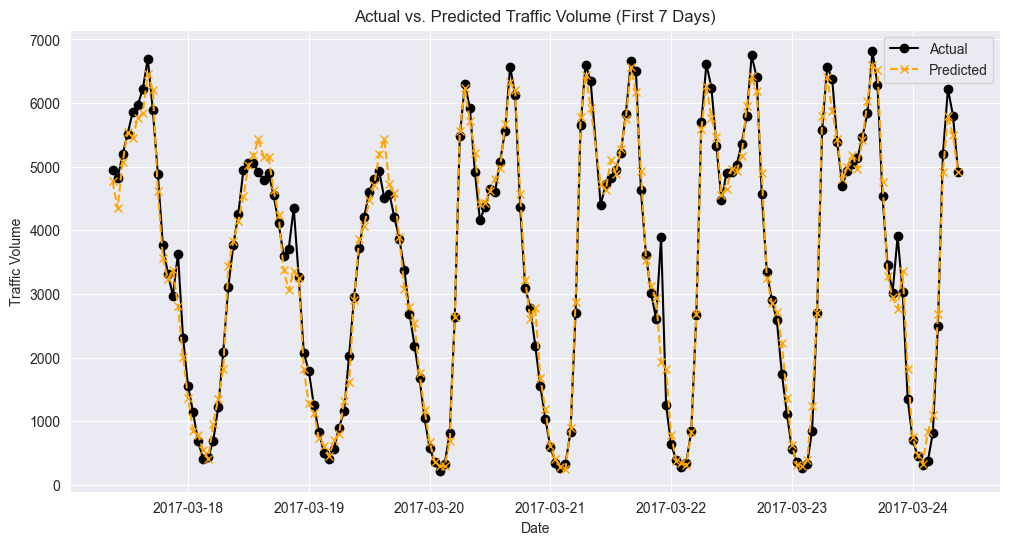

In [8]:
# Plot the actual vs. predicted traffic volume for the first 7 days
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:168], y_test.iloc[:168], label='Actual', marker='o', linestyle='-', color='black')
plt.plot(y_test.index[:168], y_val_pred[:168], label='Predicted', marker='x', linestyle='--', color='orange')
plt.title('Actual vs. Predicted Traffic Volume (First 7 Days)')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [9]:
y_pred = xgboost_model.predict(X_test)

df_test = df.iloc[split_index:].copy()  # This is the test portion of your original DataFrame
df_test['forecasted_traffic_volume'] = y_pred  # Adding the predictions

result_df = df_test[['traffic_volume', 'traffic_volume_lag_1', 'traffic_volume_lag_2', 'traffic_volume_lag_3', 'forecasted_traffic_volume']]

forecast_steps = min(720, len(X_test))

# Rename the columns
df_test_renamed = df_test.rename(columns={
    'traffic_volume': 'actual_traffic_volume',
    'traffic_volume_lag_1': 'lag_1',
    'traffic_volume_lag_2': 'lag_2',
    'traffic_volume_lag_3': 'lag_3',
    'forecasted_traffic_volume': 'forecasted_traffic'
})

# Drop the existing 'date_time' column if it exists as a separate column
if 'date_time' in df_test_renamed.columns:
    df_test_renamed.drop('date_time', axis=1, inplace=True)

# Reset the index and rename it
df_test_reformatted = df_test_renamed.reset_index()
df_test_reformatted = df_test_reformatted.rename(columns={'index': 'date_time'})

# Display the reformatted DataFrame
forecast_steps = min(720, len(df_test_reformatted))
print(df_test_reformatted[['date_time', 'actual_traffic_volume', 'lag_1', 'lag_2', 'lag_3', 'forecasted_traffic']].head(forecast_steps))


              date_time  actual_traffic_volume   lag_1   lag_2   lag_3  \
0   2017-03-17 09:00:00                 4947.0  5538.0  6114.0  4951.0   
1   2017-03-17 10:00:00                 4822.0  4947.0  5538.0  6114.0   
2   2017-03-17 11:00:00                 5191.0  4822.0  4947.0  5538.0   
3   2017-03-17 12:00:00                 5514.0  5191.0  4822.0  4947.0   
4   2017-03-17 13:00:00                 5857.0  5514.0  5191.0  4822.0   
..                  ...                    ...     ...     ...     ...   
715 2017-04-16 14:00:00                 4146.0  4152.0  4061.0  3899.0   
716 2017-04-16 15:00:00                 3998.0  4146.0  4152.0  4061.0   
717 2017-04-16 16:00:00                 4470.0  3998.0  4146.0  4152.0   
718 2017-04-16 17:00:00                 4697.0  4470.0  3998.0  4146.0   
719 2017-04-16 18:00:00                 4654.0  4697.0  4470.0  3998.0   

     forecasted_traffic  
0           4768.678711  
1           4347.013184  
2           5074.984375  
3      